# Capstone Project

## Moving to a child friendly neighborhood in Madrid - Capstone Project Weeks 4 & 5 Assignment

Download all the required dependencies:

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


Define Foursquare's Credentials and Version:

In [2]:
# The code was removed by Watson Studio for sharing.

## Data Collection & Preparation

### Chelsea

#### Chelsea's Geo Data

Download file with NY's geographic data:

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


Load the data:

In [4]:
with open('newyork_data.json') as json_data:
    NY_Data = json.load(json_data)

Define a new variable that includes relevant data:

In [5]:
NBH_Data = NY_Data['features']

Create an empty dataframe:

In [6]:
# define the dataframe columns
NY_GEO_Columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NY_GEO = pd.DataFrame(columns=NY_GEO_Columns)

Fill the new dataframe with data from the nested Python dictionaries contained in the variable:

In [7]:
for data in NBH_Data:
    brg = nbh = data['properties']['borough'] 
    nbh = data['properties']['name']
        
    latlon = data['geometry']['coordinates']
    lat = latlon[1]
    lon = latlon[0]
    
    NY_GEO = NY_GEO.append({'Borough': brg,'Neighborhood': nbh, 'Latitude': lat,'Longitude': lon}, ignore_index=True)

Make all the names uppercase:

In [8]:
NY_GEO['Borough'] = NY_GEO['Borough'].str.upper()
NY_GEO['Neighborhood'] = NY_GEO['Neighborhood'].str.upper()

Crate a new dataframe containing only data from Chelsea (Manhattan):

In [9]:
MAN_GEO = NY_GEO[NY_GEO['Borough'] == 'MANHATTAN'].reset_index(drop=True)
MAN_GEO = MAN_GEO[MAN_GEO['Neighborhood'] == 'CHELSEA'].reset_index(drop=True)
MAN_GEO

,Borough,Neighborhood,Latitude,Longitude
0,MANHATTAN,CHELSEA,40.744035,-74.003116


Use geopy library to get the latitude and longitude values of Manhattan:

In [10]:
address = 'NEW YORK, MANHATTAN'

geolocator = Nominatim(user_agent="MAN_Explorer")
MAN_location = geolocator.geocode(address)
MAN_latitude = MAN_location.latitude
MAN_longitude = MAN_location.longitude
print('The geograpical coordinates of Manhattan are {}, {}.'.format(MAN_latitude, MAN_longitude))

The geograpical coordinates of Manhattan are 40.7896239, -73.9598939.


Create a map of Manhattan with Chelsea superimposed on top:

In [11]:
# create map of Manhattan
MAN_MAP = folium.Map(location=[MAN_latitude, MAN_longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(MAN_GEO['Latitude'], MAN_GEO['Longitude'], MAN_GEO['Borough'], MAN_GEO['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#696969',
        fill=True,
        fill_color='#696969',
        fill_opacity=0.7,
        parse_html=False).add_to(MAN_MAP)  
    
MAN_MAP

#### Chelsea's Venues Data

Define a function to get the top 100 venues in a certain neighborhood within a radius of 500 meter:

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Apply the function to Chelsea:

In [13]:
MAN_VNS = getNearbyVenues(names=MAN_GEO['Neighborhood'], latitudes=MAN_GEO['Latitude'], longitudes=MAN_GEO['Longitude'])

print('{} venues were returned by Foursquare.'.format(MAN_VNS.shape[0]))
MAN_VNS.head()

CHELSEA
100 venues were returned by Foursquare.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CHELSEA,40.744035,-74.003116,Milk & Hops Chelsea,40.744751,-74.002595,Beer Bar
1,CHELSEA,40.744035,-74.003116,TAO Downtown,40.742545,-74.003837,Asian Restaurant
2,CHELSEA,40.744035,-74.003116,Bathtub Gin,40.743638,-74.003290,Speakeasy
3,CHELSEA,40.744035,-74.003116,Atlantic Theater Company (Linda Gross Theater),40.743953,-74.001476,Theater
4,CHELSEA,40.744035,-74.003116,Dil-e Punjab Deli,40.744845,-74.002528,Indian Restaurant


### Madrid

#### Madrid's Geo Data

Download file with Madrid's borough data:

In [14]:
!wget -O distritos.csv 'https://datos.madrid.es/egob/catalogo/200078-4-distritos-barrios.csv'

--2020-02-04 14:14:53--  https://datos.madrid.es/egob/catalogo/200078-4-distritos-barrios.csv
Resolving datos.madrid.es (datos.madrid.es)... 149.235.17.74
Connecting to datos.madrid.es (datos.madrid.es)|149.235.17.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://datos.madrid.es:443/datosabiertos/BDC/CALLEJERO_VIGENTE/DISTRITOS/2018/09/CALLEJERO_VIGENTE_DISTRITOS_201809.csv [following]
--2020-02-04 14:14:54--  https://datos.madrid.es/datosabiertos/BDC/CALLEJERO_VIGENTE/DISTRITOS/2018/09/CALLEJERO_VIGENTE_DISTRITOS_201809.csv
Connecting to datos.madrid.es (datos.madrid.es)|149.235.17.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1788 (1.7K) [text/csv]
Saving to: ‘distritos.csv’

distritos.csv       100%[===================>]   1.75K  --.-KB/s    in 0s      

2020-02-04 14:14:55 (58.9 MB/s) - ‘distritos.csv’ saved [1788/1788]



Create a new dataframe with data from the csv file:

In [15]:
BRG = pd.read_csv('distritos.csv', encoding='ISO-8859–1', delimiter=';', skipinitialspace=True)

BRG.head()

,Perimetro (m),Codigo de distrito,Nombre de distrito,Nombre acentuado del distrito,Numero de barrios,Superficie (m2)
0,10304,1,CENTRO,CENTRO,6,5231264
1,12834,2,ARGANZUELA,ARGANZUELA,7,6466400
2,9523,3,RETIRO,RETIRO,6,5465307
3,10862,4,SALAMANCA,SALAMANCA,6,5387243
4,13401,5,CHAMARTIN,CHAMARTÍN,6,9170122


Download file with Madrid's Neighborhoods data:

In [16]:
!wget -O barrios.csv 'https://datos.madrid.es/egob/catalogo/200078-1-distritos-barrios.csv'

--2020-02-04 14:14:55--  https://datos.madrid.es/egob/catalogo/200078-1-distritos-barrios.csv
Resolving datos.madrid.es (datos.madrid.es)... 149.235.17.74
Connecting to datos.madrid.es (datos.madrid.es)|149.235.17.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://datos.madrid.es:443/datosabiertos/BDC/CALLEJERO_VIGENTE/BARRIOS/2018/09/CALLEJERO_VIGENTE_BARRIOS_201809.csv [following]
--2020-02-04 14:14:56--  https://datos.madrid.es/datosabiertos/BDC/CALLEJERO_VIGENTE/BARRIOS/2018/09/CALLEJERO_VIGENTE_BARRIOS_201809.csv
Connecting to datos.madrid.es (datos.madrid.es)|149.235.17.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10359 (10K) [text/csv]
Saving to: ‘barrios.csv’

barrios.csv         100%[===================>]  10.12K  --.-KB/s    in 0.1s    

2020-02-04 14:14:57 (101 KB/s) - ‘barrios.csv’ saved [10359/10359]



Create a new dataframe with data from the csv file:

In [17]:
NBH = pd.read_csv('barrios.csv', encoding='ISO-8859–1', delimiter=';', skipinitialspace=True)

NBH.head()

,Codigo de barrio,Codigo de distrito al que pertenece,Nombre de barrio,Nombre acentuado del barrio,Superficie (m2),Perimetro (m)
0,1,1,PALACIO,PALACIO,1471085,5754
1,1,2,IMPERIAL,IMPERIAL,967500,4557
2,1,3,PACIFICO,PACÍFICO,750065,4005
3,1,4,RECOLETOS,RECOLETOS,870857,3927
4,1,5,EL VISO,EL VISO,1708046,5269


Create a new dataframe combining boroughs and neighborhoods in Madrid's center:

In [18]:
# rename column to use it for dataframe merging
NBH = NBH.rename(columns={'Codigo de distrito al que pertenece': 'Codigo de distrito'})

# merge dataframes
MAD = pd.merge(BRG, NBH, on='Codigo de distrito')

# remove irrelevant columns
MAD = MAD[['Nombre de distrito','Nombre de barrio']]

# remove whitespace from names
MAD['Nombre de distrito'] = MAD['Nombre de distrito'].str.strip()
MAD['Nombre de barrio'] = MAD['Nombre de barrio'].str.strip()

# remove data from neighborhoods not belonging to Madrid's center
MAD = MAD.loc[MAD['Nombre de distrito'].isin(['CENTRO','SALAMANCA','RETIRO','ARGANZUELA','CHAMBERI'])].reset_index(drop=True)

print('Madrid center has {} boroughs and {} neighborhoods.'.format(len(MAD['Nombre de distrito'].unique()), MAD.shape[0]))
MAD.head()

Madrid center has 5 boroughs and 31 neighborhoods.


,Nombre de distrito,Nombre de barrio
0,CENTRO,PALACIO
1,CENTRO,EMBAJADORES
2,CENTRO,CORTES
3,CENTRO,JUSTICIA
4,CENTRO,UNIVERSIDAD


Create an empty dataframe:

In [19]:
# define the dataframe columns
MAD_GEO_Columns = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

# instantiate the dataframe
MAD_GEO = pd.DataFrame(columns=MAD_GEO_Columns)

Fill the new dataframe with data from Madrid's boroughs and neighborhoods and geographical data from geopy library:

In [20]:
for brg, nbh in zip (MAD['Nombre de distrito'], MAD['Nombre de barrio']):
           
    address = '{}, {}'.format(brg, nbh)
      
    geolocator = Nominatim(user_agent='MAD_Explorer')
    loc = geolocator.geocode(address)
    lat = loc.latitude
    lon = loc.longitude
        
    MAD_GEO = MAD_GEO.append({'Borough': brg,'Neighborhood': nbh, 'Latitude': lat, 'Longitude': lon}, ignore_index=True)
    
MAD_GEO.head()

,Borough,Neighborhood,Latitude,Longitude
0,CENTRO,PALACIO,40.415129,-3.715618
1,CENTRO,EMBAJADORES,40.409681,-3.701644
2,CENTRO,CORTES,40.414348,-3.698525
3,CENTRO,JUSTICIA,40.423957,-3.695747
4,CENTRO,UNIVERSIDAD,40.425264,-3.706606


Use geopy library to get the latitude and longitude values of Madrid's center:

In [21]:
address = 'MADRID, SOL'

geolocator = Nominatim(user_agent='MAD_Explorer')
MAD_location = geolocator.geocode(address)
MAD_latitude = MAD_location.latitude
MAD_longitude = MAD_location.longitude
print('The geograpical coordinates of Madrid are {}, {}.'.format(MAD_latitude, MAD_longitude))

The geograpical coordinates of Madrid are 40.4178272, -3.702222089915074.


Create a map of Madrid with its neighborhoods superimposed on top:

In [22]:
# create map of Madrid
MAD_MAP = folium.Map(location=[MAD_latitude, MAD_longitude], zoom_start=13)

# add markers to map
for lat, lng, borough, neighborhood in zip(MAD_GEO['Latitude'], MAD_GEO['Longitude'], MAD_GEO['Borough'], MAD_GEO['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#696969',
        fill=True,
        fill_color='#696969',
        fill_opacity=0.7,
        parse_html=False).add_to(MAD_MAP)  
    
MAD_MAP

#### Madrid's Venues Data

Apply the function to get the top 100 venues in a certain neighborhood to Madrid:

In [23]:
MAD_VNS = getNearbyVenues(names=MAD_GEO['Neighborhood'], latitudes=MAD_GEO['Latitude'], longitudes=MAD_GEO['Longitude'])

print('{} venues were returned by Foursquare.'.format(MAD_VNS.shape[0]))
MAD_VNS.head()

PALACIO
EMBAJADORES
CORTES
JUSTICIA
UNIVERSIDAD
SOL
IMPERIAL
ACACIAS
CHOPERA
LEGAZPI
DELICIAS
PALOS DE MOGUER
ATOCHA
PACIFICO
ADELFAS
ESTRELLA
IBIZA
LOS JERONIMOS
NIÑO JESUS
RECOLETOS
GOYA
FUENTE DEL BERRO
GUINDALERA
LISTA
CASTELLANA
GAZTAMBIDE
ARAPILES
TRAFALGAR
ALMAGRO
RIOS ROSAS
VALLEHERMOSO
2041 venues were returned by Foursquare.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PALACIO,40.415129,-3.715618,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
1,PALACIO,40.415129,-3.715618,Plaza de La Almudena,40.416320,-3.713777,Plaza
2,PALACIO,40.415129,-3.715618,Cervecería La Mayor,40.415218,-3.712194,Beer Bar
3,PALACIO,40.415129,-3.715618,Corral de la Morería,40.412619,-3.714249,Performing Arts Venue
4,PALACIO,40.415129,-3.715618,Taberna Rayuela,40.413179,-3.713496,Tapas Restaurant


Check the number of venues found for each neighborhood:

In [24]:
# remove irrelevant columns
MAD_VNS_GRP_CT = MAD_VNS[[ 'Venue','Neighborhood']]

# rename relevant columns
MAD_VNS_GRP_CT = MAD_VNS_GRP_CT.rename(columns={'Venue' : 'Venues'})

# count number of venues retrieved in each neighborhood
MAD_VNS_GRP_CT = MAD_VNS_GRP_CT.groupby('Neighborhood').count().reset_index()

# set Neighborhoods as index
MAD_VNS_GRP_CT.set_index('Neighborhood', inplace=True)

# sort values in descending order
MAD_VNS_GRP_CT.sort_values(by=['Venues'], ascending=False, inplace=True)

MAD_VNS_GRP_CT

,Venues
Neighborhood,
EMBAJADORES,100
CORTES,100
GOYA,100
GAZTAMBIDE,100
RECOLETOS,100
SOL,100
JUSTICIA,100
TRAFALGAR,100
CASTELLANA,100


Create a bar chart with the number of venues retrieved for each neighborhood in Madrid:

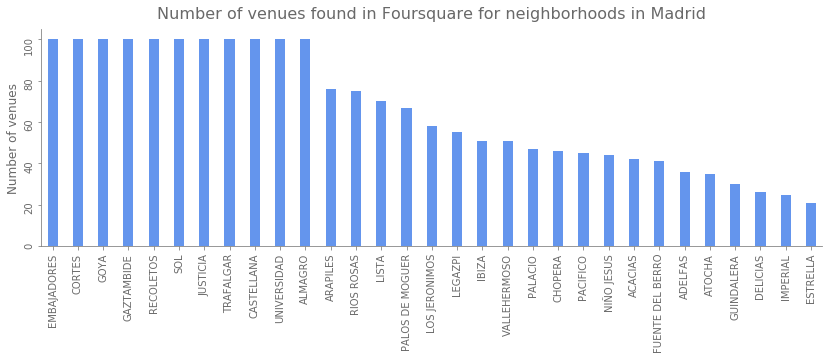

In [25]:
fs0 = 10
fs1 = 12
fs2 = 16

# create horizontal bar chart

ax = MAD_VNS_GRP_CT.plot(kind='bar', figsize=(14, 4), width=0.4, color=['#6495ED'])

# titles & labels
plt.title('Number of venues found in Foursquare for neighborhoods in Madrid', y= 1.02, fontsize=fs2, color='#696969')
plt.xlabel('')
plt.ylabel('Number of venues', fontsize=fs1, color='#696969')

# Background
ax.set_facecolor('#FFFFFF')


# axis
ax.tick_params(axis='both', direction='out', color='#808080', rotation=90, labelsize=fs0, labelcolor='#696969')

# borders        
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('#808080')        
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('#808080')

# legend
ax.legend().set_visible(False)

   
plt.show()

#### Madrid's Child Friendly Spots Data

##### Playgrounds

Download file with Madrid's playgrounds data:

In [26]:
# download csv file
!wget -O playground.csv 'https://datos.madrid.es/egob/catalogo/200652-2-areas-infantiles.csv'

--2020-02-04 14:15:24--  https://datos.madrid.es/egob/catalogo/200652-2-areas-infantiles.csv
Resolving datos.madrid.es (datos.madrid.es)... 149.235.17.74
Connecting to datos.madrid.es (datos.madrid.es)|149.235.17.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://datos.madrid.es:443/egobfiles/MANUAL/200652/AREAS_INFANTILES_2019.csv [following]
--2020-02-04 14:15:25--  https://datos.madrid.es/egobfiles/MANUAL/200652/AREAS_INFANTILES_2019.csv
Connecting to datos.madrid.es (datos.madrid.es)|149.235.17.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 253771 (248K) [text/csv]
Saving to: ‘playground.csv’

playground.csv      100%[===================>] 247.82K   412KB/s    in 0.6s    

2020-02-04 14:15:26 (412 KB/s) - ‘playground.csv’ saved [253771/253771]



Create a new dataframe with data from the csv file:

In [27]:
# create dataframe from csv
PLGRD = pd.read_csv('playground.csv', encoding='ISO-8859–1', delimiter=';', skipinitialspace=True)

# list column names to rename them
list(PLGRD.columns)

['MXASSETNUM,C,12',
 'DESCRIPTIO,C,105',
 'MINTDISTRI,C,20',
 'NOMBRE_DIS,C,25',
 'MINTBARRIO,C,10',
 'NOMBRE_BAR,C,50',
 'INSTALLDAT,D',
 'MINTTIPOVI,C,15',
 'MINTNOMBRE,C,254',
 'MINTNUMERO,C,25',
 'MINTNDP,C,20',
 'TIPO,C,254',
 'TOTAL_ELEM,N,10,0',
 'ESTADO,C,50']

Modify the dataframe to make it useful:

In [28]:
# rename relevant columns
PLGRD = PLGRD.rename(columns={'MXASSETNUM,C,12': 'Playgrounds','NOMBRE_DIS,C,25': 'Borough', 'NOMBRE_BAR,C,50' : 'Neighborhood'})

# remove data from neighborhoods not belonging to Madrid's center
PLGRD = PLGRD.loc[PLGRD['Borough'].isin(['CENTRO','SALAMANCA','RETIRO','ARGANZUELA','CHAMBERI'])].reset_index(drop=True)

# remove irrelevant columns
PLGRD = PLGRD[[ 'Playgrounds','Neighborhood']]

PLGRD.head()

,Playgrounds,Neighborhood
0,16986,RIOS ROSAS
1,16764,LEGAZPI
2,16787,NIÑO JESUS
3,16792,ESTRELLA
4,16831,GUINDALERA


Group by neighborhood and calculate the total number of playgrounds:

In [29]:
# count number of spots in each neighborhood
PLGRD_GRP = PLGRD.groupby(['Neighborhood']).count().reset_index()
PLGRD_GRP.sort_values(by=['Playgrounds'], ascending=False, inplace=True)

PLGRD_GRP.head()

,Neighborhood,Playgrounds
14,GUINDALERA,22
17,LEGAZPI,17
0,ACACIAS,16
8,DELICIAS,13
1,ADELFAS,13


##### Schools

Download file with Madrid's schools data:

In [30]:
# download csv file
!wget -O colegio.csv 'https://datos.madrid.es/egob/catalogo/212790-0-centros-educacion.csv'

--2020-02-04 14:15:26--  https://datos.madrid.es/egob/catalogo/212790-0-centros-educacion.csv
Resolving datos.madrid.es (datos.madrid.es)... 149.235.17.74
Connecting to datos.madrid.es (datos.madrid.es)|149.235.17.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://datos.madrid.es/portal/site/egob/menuitem.ac61933d6ee3c31cae77ae7784f1a5a0/?vgnextoid=00149033f2201410VgnVCM100000171f5a0aRCRD&format=csv&file=0&filename=212790-0-centros-educacion&charset=ISO-8859-1&mgmtid=6ffd9e1d29efb410VgnVCM2000000c205a0aRCRD&preview=full [following]
--2020-02-04 14:15:27--  https://datos.madrid.es/portal/site/egob/menuitem.ac61933d6ee3c31cae77ae7784f1a5a0/?vgnextoid=00149033f2201410VgnVCM100000171f5a0aRCRD&format=csv&file=0&filename=212790-0-centros-educacion&charset=ISO-8859-1&mgmtid=6ffd9e1d29efb410VgnVCM2000000c205a0aRCRD&preview=full
Connecting to datos.madrid.es (datos.madrid.es)|149.235.17.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

Create a new dataframe with data from the csv file:

In [31]:
# create dataframe from csv
SCHL = pd.read_csv('colegio.csv', encoding='ISO-8859–1', delimiter=';', skipinitialspace=True)

# list column names to rename them
list(SCHL.columns)

['PK',
 'NOMBRE',
 'DESCRIPCION-ENTIDAD',
 'HORARIO',
 'EQUIPAMIENTO',
 'TRANSPORTE',
 'DESCRIPCION',
 'ACCESIBILIDAD',
 'CONTENT-URL',
 'NOMBRE-VIA',
 'CLASE-VIAL',
 'TIPO-NUM',
 'NUM',
 'PLANTA',
 'PUERTA',
 'ESCALERAS',
 'ORIENTACION',
 'LOCALIDAD',
 'PROVINCIA',
 'CODIGO-POSTAL',
 'BARRIO',
 'DISTRITO',
 'COORDENADA-X',
 'COORDENADA-Y',
 'LATITUD',
 'LONGITUD',
 'TELEFONO',
 'FAX',
 'EMAIL',
 'TIPO',
 'Unnamed: 30']

Modify the dataframe to make it useful:

In [32]:
# rename relevant columns
SCHL = SCHL.rename(columns={'PK': 'Schools','DISTRITO': 'Borough', 'BARRIO' : 'Neighborhood'})

# remove data from neighborhoods not belonging to Madrid's center
SCHL = SCHL.loc[SCHL['Borough'].isin(['CENTRO','SALAMANCA','RETIRO','ARGANZUELA','CHAMBERI'])].reset_index(drop=True)

# remove irrelevant columns
SCHL = SCHL[[ 'Schools','Neighborhood']]

SCHL.head()

,Schools,Neighborhood
0,167390,PALACIO
1,10127337,EMBAJADORES
2,5422896,ALMAGRO
3,10692347,PALOS DE MOGUER
4,6593,DELICIAS


Group by neighborhood and calculate the total number of schools:

In [33]:
# count number of spots in each neighborhood
SCHL_GRP = SCHL.groupby(['Neighborhood']).count().reset_index()
SCHL_GRP.sort_values(by=['Schools'], ascending=False, inplace=True)

SCHL_GRP.head()

,Neighborhood,Schools
21,NIÑO JESUS,18
0,ACACIAS,17
30,VALLEHERMOSO,17
14,GUINDALERA,15
8,DELICIAS,13


##### Public Libraries

Download file with Madrid's public libraries data:

In [34]:
# download csv file
!wget -O library.csv 'https://datos.madrid.es/egob/catalogo/201747-0-bibliobuses-bibliotecas.csv'

--2020-02-04 14:15:31--  https://datos.madrid.es/egob/catalogo/201747-0-bibliobuses-bibliotecas.csv
Resolving datos.madrid.es (datos.madrid.es)... 149.235.17.74
Connecting to datos.madrid.es (datos.madrid.es)|149.235.17.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://datos.madrid.es/portal/site/egob/menuitem.ac61933d6ee3c31cae77ae7784f1a5a0/?vgnextoid=00149033f2201410VgnVCM100000171f5a0aRCRD&format=csv&file=0&filename=201747-0-bibliobuses-bibliotecas&charset=ISO-8859-1&mgmtid=ed35401429b83410VgnVCM1000000b205a0aRCRD&preview=full [following]
--2020-02-04 14:15:31--  https://datos.madrid.es/portal/site/egob/menuitem.ac61933d6ee3c31cae77ae7784f1a5a0/?vgnextoid=00149033f2201410VgnVCM100000171f5a0aRCRD&format=csv&file=0&filename=201747-0-bibliobuses-bibliotecas&charset=ISO-8859-1&mgmtid=ed35401429b83410VgnVCM1000000b205a0aRCRD&preview=full
Connecting to datos.madrid.es (datos.madrid.es)|149.235.17.74|:443... connected.
HTTP request sent, awaiting re

Create a new dataframe with data from the csv file:

In [35]:
# create dataframe from csv
LBR = pd.read_csv('library.csv', encoding='ISO-8859–1', delimiter=';', skipinitialspace=True)

# list column names to rename them
list(LBR.columns)

['PK',
 'NOMBRE',
 'DESCRIPCION-ENTIDAD',
 'HORARIO',
 'EQUIPAMIENTO',
 'TRANSPORTE',
 'DESCRIPCION',
 'ACCESIBILIDAD',
 'CONTENT-URL',
 'NOMBRE-VIA',
 'CLASE-VIAL',
 'TIPO-NUM',
 'NUM',
 'PLANTA',
 'PUERTA',
 'ESCALERAS',
 'ORIENTACION',
 'LOCALIDAD',
 'PROVINCIA',
 'CODIGO-POSTAL',
 'BARRIO',
 'DISTRITO',
 'COORDENADA-X',
 'COORDENADA-Y',
 'LATITUD',
 'LONGITUD',
 'TELEFONO',
 'FAX',
 'EMAIL',
 'TIPO',
 'Unnamed: 30']

Modify the dataframe to make it useful:

In [36]:
# rename relevant columns
LBR = LBR.rename(columns={'PK': 'Libraries','DISTRITO': 'Borough', 'BARRIO' : 'Neighborhood'})

# remove data from neighborhoods not belonging to Madrid's center
LBR = LBR.loc[LBR['Borough'].isin(['CENTRO','SALAMANCA','RETIRO','ARGANZUELA','CHAMBERI'])].reset_index(drop=True)

# remove irrelevant columns
LBR = LBR[[ 'Libraries','Neighborhood']]

LBR.head()

,Libraries,Neighborhood
0,1774,ADELFAS
1,1764,TRAFALGAR
2,1882,UNIVERSIDAD
3,1762,GUINDALERA
4,6893633,LOS JERONIMOS


Group by neighborhood and calculate the total number of public libraries:

In [37]:
# count number of spots in each neighborhood
LBR_GRP = LBR.groupby(['Neighborhood']).count().reset_index()
LBR_GRP.sort_values(by=['Libraries'], ascending=False, inplace=True)

LBR_GRP.head()

,Neighborhood,Libraries
3,EMBAJADORES,2
4,GUINDALERA,2
0,ACACIAS,1
1,ADELFAS,1
2,DELICIAS,1


##### Hospitals / Medical centers

Download file with Madrid's hospitals / medical centers data:

In [38]:
# download csv file
!wget -O hospital.csv 'https://datos.madrid.es/egob/catalogo/212769-0-atencion-medica.csv'

--2020-02-04 14:15:32--  https://datos.madrid.es/egob/catalogo/212769-0-atencion-medica.csv
Resolving datos.madrid.es (datos.madrid.es)... 149.235.17.74
Connecting to datos.madrid.es (datos.madrid.es)|149.235.17.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://datos.madrid.es/portal/site/egob/menuitem.ac61933d6ee3c31cae77ae7784f1a5a0/?vgnextoid=00149033f2201410VgnVCM100000171f5a0aRCRD&format=csv&file=0&filename=212769-0-atencion-medica&charset=ISO-8859-1&mgmtid=da7437ac37efb410VgnVCM2000000c205a0aRCRD&preview=full [following]
--2020-02-04 14:15:33--  https://datos.madrid.es/portal/site/egob/menuitem.ac61933d6ee3c31cae77ae7784f1a5a0/?vgnextoid=00149033f2201410VgnVCM100000171f5a0aRCRD&format=csv&file=0&filename=212769-0-atencion-medica&charset=ISO-8859-1&mgmtid=da7437ac37efb410VgnVCM2000000c205a0aRCRD&preview=full
Connecting to datos.madrid.es (datos.madrid.es)|149.235.17.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length:

Create a new dataframe with data from the csv file:

In [39]:
# create dataframe from csv
HSPT = pd.read_csv('hospital.csv', encoding='ISO-8859–1', delimiter=';', skipinitialspace=True)

# list column names to rename them
list(HSPT.columns)

['PK',
 'NOMBRE',
 'DESCRIPCION-ENTIDAD',
 'HORARIO',
 'EQUIPAMIENTO',
 'TRANSPORTE',
 'DESCRIPCION',
 'ACCESIBILIDAD',
 'CONTENT-URL',
 'NOMBRE-VIA',
 'CLASE-VIAL',
 'TIPO-NUM',
 'NUM',
 'PLANTA',
 'PUERTA',
 'ESCALERAS',
 'ORIENTACION',
 'LOCALIDAD',
 'PROVINCIA',
 'CODIGO-POSTAL',
 'BARRIO',
 'DISTRITO',
 'COORDENADA-X',
 'COORDENADA-Y',
 'LATITUD',
 'LONGITUD',
 'TELEFONO',
 'FAX',
 'EMAIL',
 'TIPO',
 'Unnamed: 30']

Modify the dataframe to make it useful:

In [40]:
# rename relevant columns
HSPT = HSPT.rename(columns={'PK': 'Hospitals','DISTRITO': 'Borough', 'BARRIO' : 'Neighborhood'})

# remove data from neighborhoods not belonging to Madrid's center
HSPT = HSPT.loc[HSPT['Borough'].isin(['CENTRO','SALAMANCA','RETIRO','ARGANZUELA','CHAMBERI'])].reset_index(drop=True)

# remove irrelevant columns
HSPT = HSPT[[ 'Hospitals','Neighborhood']]

HSPT.head()

,Hospitals,Neighborhood
0,11867,CHOPERA
1,11899,JUSTICIA
2,5855213,JUSTICIA
3,9085,FUENTE DEL BERRO
4,9092,RIOS ROSAS


Group by neighborhood and calculate the total number of hospitals:

In [41]:
# count number of spots in each neighborhood
HSPT_GRP = HSPT.groupby(['Neighborhood']).count().reset_index()
HSPT_GRP.sort_values(by=['Hospitals'], ascending=False, inplace=True)

HSPT_GRP.head()

,Neighborhood,Hospitals
18,LISTA,8
27,VALLEHERMOSO,5
23,RIOS ROSAS,4
15,IMPERIAL,4
13,GUINDALERA,4


### Chelsea's & Madrid's Data

#### Geo Data

Concatenate geographical data from Chelsea and Madrid's neighborhoods:

In [42]:
MAN_MAD_GEO = pd.concat([MAN_GEO,MAD_GEO], ignore_index=True, sort=False)

MAN_MAD_GEO.head()

,Borough,Neighborhood,Latitude,Longitude
0,MANHATTAN,CHELSEA,40.744035,-74.003116
1,CENTRO,PALACIO,40.415129,-3.715618
2,CENTRO,EMBAJADORES,40.409681,-3.701644
3,CENTRO,CORTES,40.414348,-3.698525
4,CENTRO,JUSTICIA,40.423957,-3.695747


## Data Analysis

### Exploring Chelsea's Venues

One hot encode Chelsea's venues category data:

In [43]:
# one hot encoding
MAN_VNS_OH = pd.get_dummies(MAN_VNS[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
MAN_VNS_OH['Neighborhood'] = MAN_VNS['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [MAN_VNS_OH.columns[-1]] + list(MAN_VNS_OH.columns[:-1])
MAN_VNS_OH = MAN_VNS_OH[fixed_columns]

Calculate the mean of the frequency of occurrence of each category:

In [44]:
MAN_VNS_GRP_OH = MAN_VNS_OH.groupby('Neighborhood').mean().reset_index()

MAN_VNS_GRP_OH.head()

,Neighborhood,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Bar,Bookstore,Breakfast Spot,Burger Joint,Butcher,Café,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Creperie,Cupcake Shop,Cycle Studio,Dessert Shop,Electronics Store,Fish Market,Flea Market,French Restaurant,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hotel,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Market,Men's Store,Mexican Restaurant,Nightclub,Noodle House,Office,Paella Restaurant,Park,Pet Store,Photography Studio,Physical Therapist,Pizza Place,Poke Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Smoothie Shop,Speakeasy,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Wine Shop,Women's Store
0,CHELSEA,0.03,0.02,0.01,0.05,0.01,0.01,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.02,0.06,0.01,0.01,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.04,0.01,0.01,0.04,0.02,0.02,0.02,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.02,0.01,0.02,0.01,0.03,0.01,0.03,0.01


Define a function to sort the venues in descending order:

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a dataframe to display the top 10 venues for Chelsea:

In [46]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
MAN_VNS_GRP_SRT = pd.DataFrame(columns=columns)
MAN_VNS_GRP_SRT['Neighborhood'] = MAN_VNS_GRP_OH['Neighborhood']

for ind in np.arange(MAN_VNS_GRP_OH.shape[0]):
    MAN_VNS_GRP_SRT.iloc[ind, 1:] = return_most_common_venues(MAN_VNS_GRP_OH.iloc[ind, :], num_top_venues)

MAN_VNS_GRP_SRT.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CHELSEA,Coffee Shop,Bakery,Ice Cream Shop,Italian Restaurant,Hotel,Nightclub,Wine Shop,American Restaurant,Theater,Breakfast Spot


### Exploring Madrid's Venues

One hot encoding of Madrid's venues category data:

In [47]:
# one hot encoding
MAD_VNS_OH = pd.get_dummies(MAD_VNS[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
MAD_VNS_OH.drop(['Neighborhood'], axis=1, inplace=True)

MAD_VNS_OH['Neighborhood'] = MAD_VNS['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [MAD_VNS_OH.columns[-1]] + list(MAD_VNS_OH.columns[:-1])
MAD_VNS_OH = MAD_VNS_OH[fixed_columns]

Group by neighborhood and calculate the mean of the frequency of occurrence of each category:

In [48]:
MAD_VNS_GRP_OH = MAD_VNS_OH.groupby('Neighborhood').mean().reset_index()

MAD_VNS_GRP_OH.head()

,Neighborhood,Accessories Store,Adult Boutique,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Brewery,Bridge,Building,Burger Joint,Burrito Place,Cafeteria,Café,Cajun / Creole Restaurant,Casino,Cheese Shop,Chinese Restaurant,Church,Circus,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Shop,Donut Shop,Dumpling Restaurant,Electronics Store,Embassy / Consulate,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Optical Shop,Other Event,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tattoo Parlor,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trade School,Train Station,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,ACACIAS,0.0,0.0,0.000000,0.0,0.071429,0.00,0.0,0.000000,0.000000,0.000000,0.0,0.047619,0.119048,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.023810,0.0,0.0,0.000000,0.000000,0.00,0.0,0.023810,0.000000,0.0,0.023810,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.02381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.02381,0.0,0.0,0.0,0.000000,0.02381,0.0,0.000000,0.023810,0.0,0.000000,0.000000,0.0,0.00,0.00,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.023810,0.02381,0.023810,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.02381,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.02381,0.0,0.023810,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.02381,0.0,0.

Create a dataframe to display the top 10 venues for each neighborhood:

In [49]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
MAD_VNS_GRP_SRT = pd.DataFrame(columns=columns)
MAD_VNS_GRP_SRT['Neighborhood'] = MAD_VNS_GRP_OH['Neighborhood']

for ind in np.arange(MAD_VNS_GRP_OH.shape[0]):
    MAD_VNS_GRP_SRT.iloc[ind, 1:] = return_most_common_venues(MAD_VNS_GRP_OH.iloc[ind, :], num_top_venues)

MAD_VNS_GRP_SRT.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ACACIAS,Bar,Art Gallery,Spanish Restaurant,Tapas Restaurant,Bakery,Pizza Place,Plaza,Bookstore,Snack Place,Liquor Store
1,ADELFAS,Grocery Store,Hotel,Bakery,Supermarket,Spanish Restaurant,Fast Food Restaurant,Tapas Restaurant,Bar,Brewery,Soccer Field
2,ALMAGRO,Spanish Restaurant,Restaurant,Hotel,Mediterranean Restaurant,Supermarket,Bar,Japanese Restaurant,French Restaurant,Cocktail Bar,Plaza
3,ARAPILES,Spanish Restaurant,Bar,Bakery,Café,Burrito Place,Restaurant,Ice Cream Shop,Sandwich Place,Burger Joint,Tapas Restaurant
4,ATOCHA,Bar,Spanish Restaurant,Café,Italian Restaurant,Restaurant,Bakery,Coffee Shop,Polish Restaurant,Plaza,Food Truck


### Clustering Chelsea & Madrid's Neighborhoods

Concatenate dataframes with one hot encoding data from Chelsea and Madrid's neighborhoods:

In [50]:
MAN_MAD_VNS_GRP_OH = pd.concat([MAN_VNS_GRP_OH,MAD_VNS_GRP_OH], ignore_index=True, sort=False)
MAN_MAD_VNS_GRP_OH.replace(np.nan, 0, inplace=True)

MAN_MAD_VNS_GRP_OH.head()

,Neighborhood,American Restaurant,Art Gallery,Asian Restaurant,Bakery,Bar,Beer Bar,Bookstore,Breakfast Spot,Burger Joint,Butcher,Café,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Theater,Creperie,Cupcake Shop,Cycle Studio,Dessert Shop,Electronics Store,Fish Market,Flea Market,French Restaurant,Gift Shop,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Hotel,Ice Cream Shop,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Market,Men's Store,Mexican Restaurant,Nightclub,Noodle House,Office,Paella Restaurant,Park,Pet Store,Photography Studio,Physical Therapist,Pizza Place,Poke Place,Sandwich Place,Scenic Lookout,Seafood Restaurant,Smoothie Shop,Speakeasy,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant,Theater,Vegetarian / Vegan Restaurant,Wine Shop,Women's Store,Accessories Store,Adult Boutique,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Athletics & Sports,BBQ Joint,Bagel Shop,Basketball Stadium,Bed & Breakfast,Beer Garden,Beer Store,Big Box Store,Bistro,Board Shop,Boutique,Boxing Gym,Brewery,Bridge,Building,Burrito Place,Cafeteria,Cajun / Creole Restaurant,Casino,Church,Circus,City Hall,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Diner,Discount Store,Dive Shop,Donut Shop,Dumpling Restaurant,Embassy / Consulate,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Flower Shop,Food,Food & Drink Shop,Food Stand,Food Truck,Football Stadium,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Gymnastics Gym,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel Bar,Indie Movie Theater,Indie Theater,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Korean Restaurant,Lake,Latin American Restaurant,Library,Liquor Store,Lounge,Mediterranean Restaurant,Metro Station,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,North Indian Restaurant,Optical Shop,Other Event,Other Nightlife,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Café,Pharmacy,Piano Bar,Pie Shop,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Post Office,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Science Museum,Sculpture Garden,Shoe Store,Shopping Mall,Skate Park,Snack Place,Soccer Field,South American Restaurant,Souvlaki Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Swiss Restaurant,Tattoo Parlor,Tea Room,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trade School,Train Station,Used Bookstore,Venezuelan Restaurant,Whisky Bar,Wine Bar,Yoga Studio
0,CHELSEA,0.030000,0.020000,0.010000,0.050000,0.010000,0.010000,0.020000,0.02,0.020000,0.01,0.010000,0.010000,0.01,0.01,0.020000,0.060000,0.01,0.01,0.02,0.02,0.010000,0.01,0.01,0.01000,0.01,0.010000,0.010000,0.010000,0.01000,0.01,0.030000,0.040000,0.01,0.01,0.040000,0.02,0.020000,0.020000,0.010000,0.03,0.01,0.01,0.01,0.01000,0.01,0.01,0.01,0.010000,0.01,0.010000,0.01,0.020000,0.01,0.01,0.020000,0.01,0.020000,0.01,0.030000,0.01,0.030000,0.01,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,

Run *k*-means to cluster the neighborhoods into 4 clusters:

In [51]:
# set number of clusters
kclusters = 4

MAN_MAD_VNS_GRP_OH_K = MAN_MAD_VNS_GRP_OH.drop('Neighborhood', axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(MAN_MAD_VNS_GRP_OH_K)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 2, 2, 1, 3, 3, 1, 0, 1, 0, 0, 3, 2, 0, 1, 1, 1, 3, 0, 3, 1, 1,
       3, 2, 0, 1, 1, 2, 0, 1, 0, 2], dtype=int32)

Concatenate dataframes with the top 10 venues in Chelsea and Madrid's neighborhoods:

In [52]:
MAN_MAD_VNS_GRP_SRT = pd.concat([MAN_VNS_GRP_SRT,MAD_VNS_GRP_SRT], ignore_index=True, sort=False)

MAN_MAD_VNS_GRP_SRT.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CHELSEA,Coffee Shop,Bakery,Ice Cream Shop,Italian Restaurant,Hotel,Nightclub,Wine Shop,American Restaurant,Theater,Breakfast Spot
1,ACACIAS,Bar,Art Gallery,Spanish Restaurant,Tapas Restaurant,Bakery,Pizza Place,Plaza,Bookstore,Snack Place,Liquor Store
2,ADELFAS,Grocery Store,Hotel,Bakery,Supermarket,Spanish Restaurant,Fast Food Restaurant,Tapas Restaurant,Bar,Brewery,Soccer Field
3,ALMAGRO,Spanish Restaurant,Restaurant,Hotel,Mediterranean Restaurant,Supermarket,Bar,Japanese Restaurant,French Restaurant,Cocktail Bar,Plaza
4,ARAPILES,Spanish Restaurant,Bar,Bakery,Café,Burrito Place,Restaurant,Ice Cream Shop,Sandwich Place,Burger Joint,Tapas Restaurant


Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood:

In [53]:
# add clustering labels
#MAN_MAD_VNS_GRP_SRT.drop(columns=['Cluster Labels'], inplace=True)
MAN_MAD_VNS_GRP_SRT.insert(0, 'Cluster Labels', kmeans.labels_)

MAN_MAD_VNS_GRP_SRT_K = MAN_MAD_GEO

# add latitude/longitude
MAN_MAD_VNS_GRP_SRT_K = MAN_MAD_VNS_GRP_SRT_K.join(MAN_MAD_VNS_GRP_SRT.set_index('Neighborhood'), on='Neighborhood')

MAN_MAD_VNS_GRP_SRT_K.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,MANHATTAN,CHELSEA,40.744035,-74.003116,0,Coffee Shop,Bakery,Ice Cream Shop,Italian Restaurant,Hotel,Nightclub,Wine Shop,American Restaurant,Theater,Breakfast Spot
1,CENTRO,PALACIO,40.415129,-3.715618,0,Tapas Restaurant,Plaza,Spanish Restaurant,Historic Site,Restaurant,Beer Bar,Vegetarian / Vegan Restaurant,Music Venue,Bar,Japanese Restaurant
2,CENTRO,EMBAJADORES,40.409681,-3.701644,0,Bar,Café,Spanish Restaurant,Hostel,Tapas Restaurant,Hotel,Art Gallery,Plaza,Theater,Coffee Shop
3,CENTRO,CORTES,40.414348,-3.698525,1,Hotel,Spanish Restaurant,Restaurant,Bar,Plaza,Mediterranean Restaurant,Theater,Café,Cocktail Bar,Bookstore
4,CENTRO,JUSTICIA,40.423957,-3.695747,0,Restaurant,Bakery,Spanish Restaurant,Hotel,Vegetarian / Vegan Restaurant,Italian Restaurant,Gay Bar,American Restaurant,Flower Shop,Deli / Bodega


Create a new dataframe that includes the top 10 venues for the neighborhoods in Chelsea's cluster:

In [54]:
# Obtain Chelsea's cluster
CLS_K = MAN_MAD_VNS_GRP_SRT_K.loc[MAN_MAD_VNS_GRP_SRT_K['Neighborhood']=='CHELSEA', 'Cluster Labels'].values[0]

# filter neighbborhoods within Chelsea's cluster
MAN_MAD_VNS_GRP_SRT_CLS_K = MAN_MAD_VNS_GRP_SRT_K.loc[MAN_MAD_VNS_GRP_SRT_K['Cluster Labels'] == CLS_K, MAN_MAD_VNS_GRP_SRT_K.columns[[1] + list(range(5, MAN_MAD_VNS_GRP_SRT_K.shape[1]))]]

MAN_MAD_VNS_GRP_SRT_CLS_K

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CHELSEA,Coffee Shop,Bakery,Ice Cream Shop,Italian Restaurant,Hotel,Nightclub,Wine Shop,American Restaurant,Theater,Breakfast Spot
1,PALACIO,Tapas Restaurant,Plaza,Spanish Restaurant,Historic Site,Restaurant,Beer Bar,Vegetarian / Vegan Restaurant,Music Venue,Bar,Japanese Restaurant
2,EMBAJADORES,Bar,Café,Spanish Restaurant,Hostel,Tapas Restaurant,Hotel,Art Gallery,Plaza,Theater,Coffee Shop
4,JUSTICIA,Restaurant,Bakery,Spanish Restaurant,Hotel,Vegetarian / Vegan Restaurant,Italian Restaurant,Gay Bar,American Restaurant,Flower Shop,Deli / Bodega
5,UNIVERSIDAD,Bar,Cocktail Bar,Bookstore,Theater,Tapas Restaurant,Café,Chinese Restaurant,Restaurant,Argentinian Restaurant,Spanish Restaurant
6,SOL,Hotel,Tapas Restaurant,Spanish Restaurant,Clothing Store,Plaza,Restaurant,Bookstore,Art Museum,Coffee Shop,Theater
9,CHOPERA,Park,Burger Joint,Art Gallery,Tapas Restaurant,Coffee Shop,Spanish Restaurant,Bar,Italian Restaurant,Restaurant,Mediterranean Restaurant
11,DELICIAS,Snack Place,Coffee Shop,Restaurant,Chinese Restaurant,Mediterranean Restaurant,Bakery,Gym / Fitness Center,Farmers Market,Flea Market,Museum
26,GAZTAMBIDE,Spanish Restaurant,Bar,Café,Tapas Restaurant,Restaurant,Coffee Shop,Supermarket,Pizza Place,Theater,Clothing Store


Create a map of Manhattan with clusters superimposed on top:

In [55]:
# create map of Manhattan
MAN_k_MAP = folium.Map(location=[MAN_latitude, MAN_longitude], zoom_start=12)

# set color scheme for the clusters
rainbow = ['#DCDCDC', '#696969', '#808080', '#6495ED']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MAN_MAD_VNS_GRP_SRT_K['Latitude'], MAN_MAD_VNS_GRP_SRT_K['Longitude'], MAN_MAD_VNS_GRP_SRT_K['Neighborhood'], MAN_MAD_VNS_GRP_SRT_K['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(MAN_k_MAP)
       
MAN_k_MAP

Create a map of Madrid with clusters superimposed on top:

In [56]:
# create map of Madrid
MAD_k_MAP = folium.Map(location=[MAD_latitude, MAD_longitude], zoom_start=13)

# set color scheme for the clusters
rainbow = ['#A9A9A9', '#696969', '#808080', '#6495ED']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MAN_MAD_VNS_GRP_SRT_K['Latitude'], MAN_MAD_VNS_GRP_SRT_K['Longitude'], MAN_MAD_VNS_GRP_SRT_K['Neighborhood'], MAN_MAD_VNS_GRP_SRT_K['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster-1],
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
         #fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(MAD_k_MAP)
       
MAD_k_MAP

### Exploring Madrid's Child Friendly Neighborhoods

Create a new dataframe with Madrid's child friendly spots:

In [57]:
MAD_CHLD_FRND = pd.DataFrame(columns=['Neighborhood'])
MAD_CHLD_FRND = pd.merge(MAD_CHLD_FRND, PLGRD_GRP, how='outer', on="Neighborhood")
MAD_CHLD_FRND = pd.merge(MAD_CHLD_FRND, SCHL_GRP, how='outer', on="Neighborhood")
MAD_CHLD_FRND = pd.merge(MAD_CHLD_FRND, LBR_GRP, how='outer', on="Neighborhood")
MAD_CHLD_FRND = pd.merge(MAD_CHLD_FRND, HSPT_GRP, how='outer', on="Neighborhood")

MAD_CHLD_FRND.set_index('Neighborhood', inplace=True)
MAD_CHLD_FRND.replace(np.nan, 0, inplace=True)
MAD_CHLD_FRND = MAD_CHLD_FRND.astype('int')

MAD_CHLD_FRND.head()

,Playgrounds,Schools,Libraries,Hospitals
Neighborhood,,,,
GUINDALERA,22,15,2,4
LEGAZPI,17,6,0,1
ACACIAS,16,17,1,2
DELICIAS,13,13,1,1
ADELFAS,13,6,1,2


Create a box plot with the distribution of child friendly spots within the different neighborhoods:

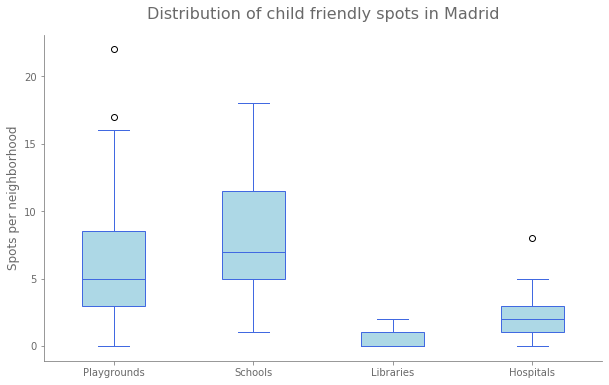

In [58]:
fs0 = 10
fs1 = 12
fs2 = 16

labels = list(MAD_CHLD_FRND.columns)

# create boxplot
fig, ax = plt.subplots(figsize=(10, 6))

bp = ax.boxplot(MAD_CHLD_FRND.transpose(), patch_artist=True, labels=labels)

# titles & labels
ax.set_title("Distribution of child friendly spots in Madrid", y= 1.03, fontsize=fs2, color='#696969')
ax.set_ylabel('Spots per neighborhood', fontsize=fs1, color='#696969')

# Background
ax.set_facecolor('#FFFFFF')
fig.set_facecolor('#FFFFFF')

# axis
ax.tick_params(axis='both', direction='out', color='#808080', labelsize=fs0, labelcolor='#696969')

# borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('#808080')

# set box colors
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='#4169E1')
    
for patch in bp['boxes']:
    patch.set(facecolor='#ADD8E6')
    


    
plt.show()

Create a bar chart with the number of child friendly spots in each neighborhood:

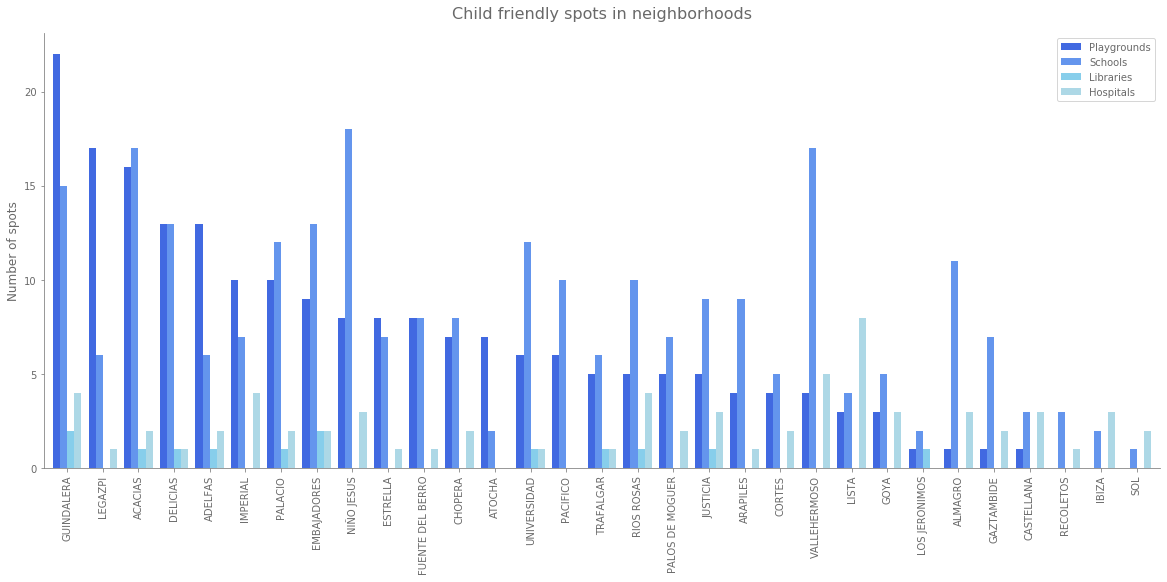

In [59]:
fs0 = 10
fs1 = 12
fs2 = 16

# create horizontal bar chart
ax = MAD_CHLD_FRND.plot(kind='bar', figsize=(20, 8), width=0.8, color=['#4169E1', '#6495ED', '#87CEEB', '#ADD8E6'])

# titles & labels
plt.title('Child friendly spots in neighborhoods', y= 1.02, fontsize=fs2, color='#696969')
plt.xlabel('')
plt.ylabel('Number of spots', fontsize=fs1, color='#696969')

# Background
ax.set_facecolor('#FFFFFF')


# axis
ax.tick_params(axis='both', direction='out', color='#808080', labelsize=fs0, labelcolor='#696969')

# borders        
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_color('#808080')        
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('#808080')

# legend
leg = ax.legend()
for text in leg.get_texts():
    plt.setp(text, fontsize=fs0, color = '#696969')
    
plt.show()

Create a new dataframe with child friendly spots in Chelsea's cluster neighborhoods:

In [60]:
# filtering the desired values
MAD_CHLD_FRND_CLS_K = MAD_CHLD_FRND.loc[MAD_CHLD_FRND.index.isin(['JUSTICIA','UNIVERSIDAD','CHOPERA','ESTRELLA','NIÑO JESUS'])]

MAD_CHLD_FRND_CLS_K

,Playgrounds,Schools,Libraries,Hospitals
Neighborhood,,,,
NIÑO JESUS,8,18,0,3
ESTRELLA,8,7,0,1
CHOPERA,7,8,0,2
UNIVERSIDAD,6,12,1,1
JUSTICIA,5,9,1,3
